# Learning GAN and WGAN for a synthetic 2-dimensional dataset

<br/><br/>
<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2425/tp3_generative_networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

This practical session contains
- "QUESTION" fields in the text
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebooks on Google Colab.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

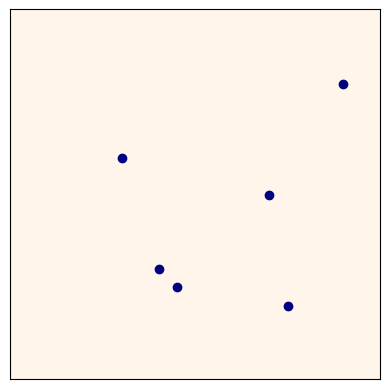

In [2]:
d = 2   # dimension of the data points
n = 6   # number of data points

y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2

y[1, 0] = 0.75
y[1, 1] = 0.8

y[2, 0] = 0.3
y[2, 1] = 0.4

y[3, 0] = 0.4
y[3, 1] = 0.7

y[4, 0] = 0.45
y[4, 1] = 0.75

y[5, 0] = 0.7
y[5, 1] = 0.5

nu = torch.ones(n, device=device)/n  # equal masses (nu is the empirical measure of the data)

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

In [5]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

torch.Size([100, 2])


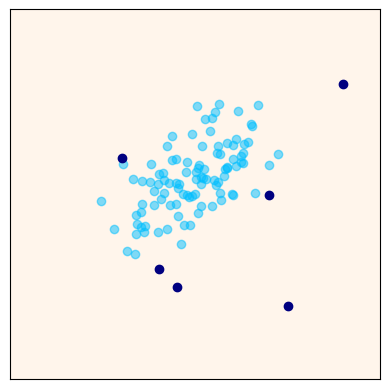

In [6]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

z = torch.randn(b, n_in).to(device)
x = G(z)
print(x.shape)

xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

# Exercise 1: WGAN Learning

## Discriminator Architecture

QUESTION: Examine the layers and parameters of the following discriminative network.

In [6]:
class DWGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DWGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

[0/1000], -0.010782


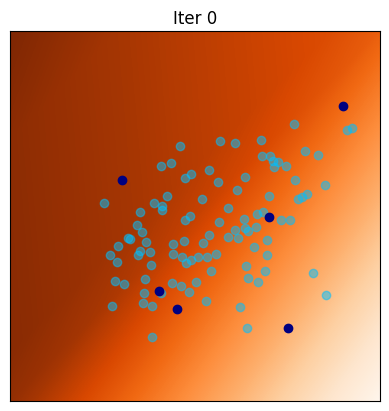

[100/1000], 0.000760


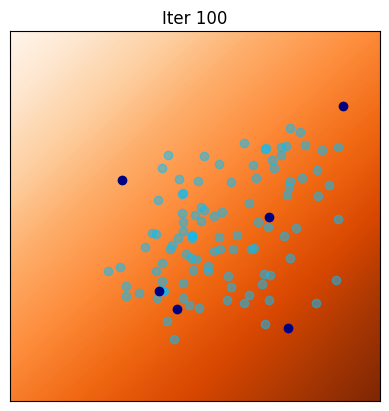

[200/1000], 0.002203


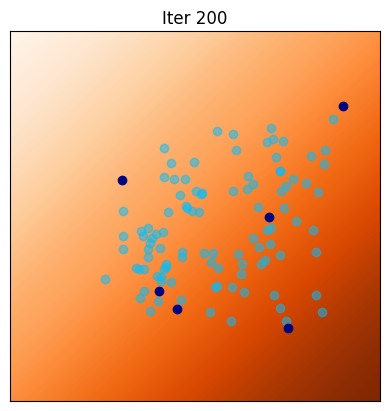

[300/1000], 0.003413


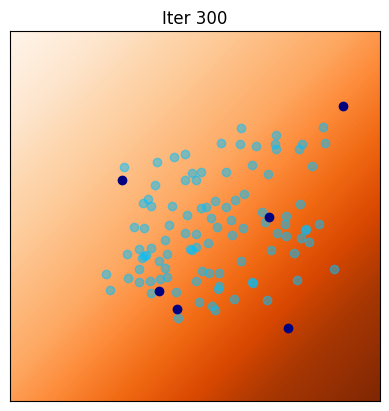

[400/1000], 0.002564


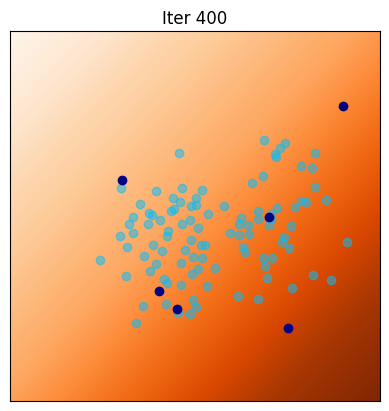

[500/1000], 0.004775


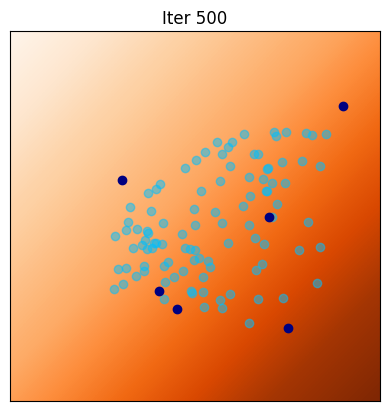

[600/1000], 0.003655


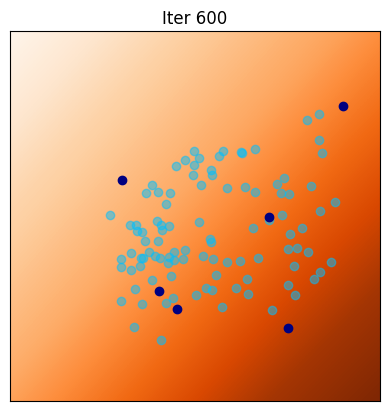

[700/1000], 0.004833


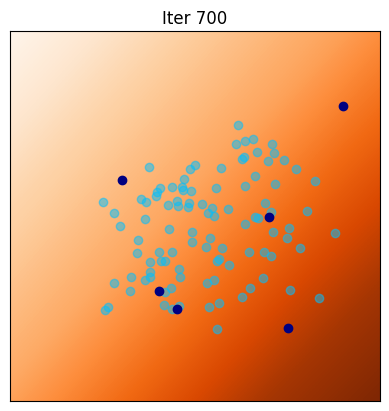

[800/1000], 0.002552


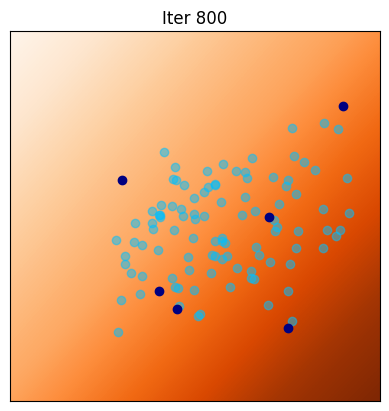

[900/1000], 0.004703


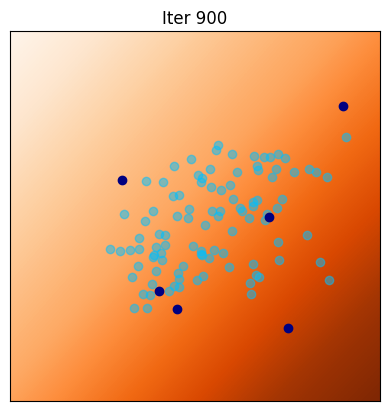

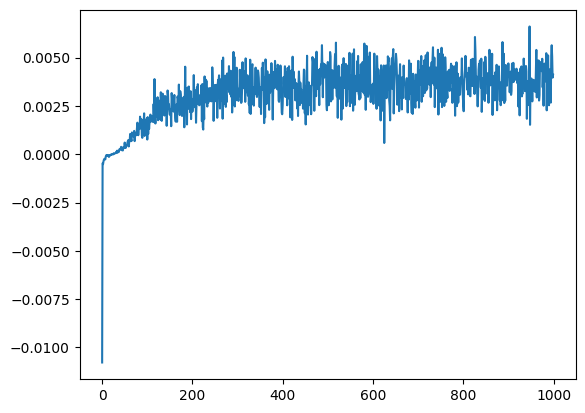

In [87]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

criterion = nn.CrossEntropyLoss()

for iter in range(0,niterD):
    optimD.zero_grad()
    z = torch.randn(b, n_in).to(device)
    g_z = G(z).detach()
    ### UPDATE OF D ###
    Dloss = -torch.mean(D(y)) + torch.mean(D(g_z))
    Dloss.backward()
    optimD.step()
    ### ... (weight clipping step) ... ###
    for param in D.parameters():
        param.data.clamp_(-clip_value, clip_value)
        
    ### SAVE LOSS ###
    Dlosst = -Dloss.item()
    Dlosses.append(Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

QUESTION: Now, train both the generator and discriminator with the WGAN loss and weight clipping.

  1%|▊                                                                                   | 1/99 [00:04<07:24,  4.54s/it]

[1/100] 	Loss_D: -0.0022	Loss_G: 0.0309


  2%|█▋                                                                                  | 2/99 [00:08<07:07,  4.41s/it]

[2/100] 	Loss_D: -0.0069	Loss_G: -0.0047


  3%|██▌                                                                                 | 3/99 [00:13<06:59,  4.37s/it]

[3/100] 	Loss_D: -0.0035	Loss_G: -0.0046


  4%|███▍                                                                                | 4/99 [00:17<06:53,  4.36s/it]

[4/100] 	Loss_D: -0.0011	Loss_G: -0.0050


  5%|████▏                                                                               | 5/99 [00:21<06:48,  4.35s/it]

[5/100] 	Loss_D: -0.0064	Loss_G: -0.0610


  6%|█████                                                                               | 6/99 [00:26<06:42,  4.32s/it]

[6/100] 	Loss_D: -0.0121	Loss_G: -0.0716


  7%|█████▉                                                                              | 7/99 [00:30<06:40,  4.36s/it]

[7/100] 	Loss_D: -0.0005	Loss_G: -0.1546


  8%|██████▊                                                                             | 8/99 [00:34<06:36,  4.36s/it]

[8/100] 	Loss_D: -0.0021	Loss_G: -0.0402


  9%|███████▋                                                                            | 9/99 [00:39<06:35,  4.39s/it]

[9/100] 	Loss_D: -0.0079	Loss_G: -0.0150
[10/100] 	Loss_D: -0.0044	Loss_G: -0.0177


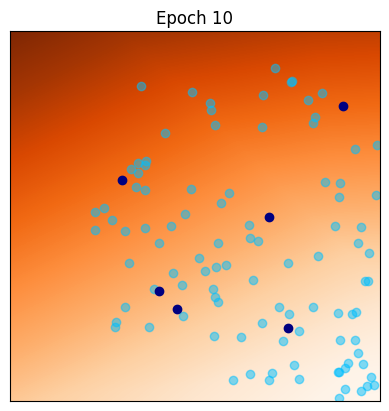

 11%|█████████▏                                                                         | 11/99 [00:48<06:28,  4.41s/it]

[11/100] 	Loss_D: -0.0021	Loss_G: -0.0178


 12%|██████████                                                                         | 12/99 [00:52<06:24,  4.42s/it]

[12/100] 	Loss_D: -0.0032	Loss_G: -0.1289


 13%|██████████▉                                                                        | 13/99 [00:57<06:18,  4.40s/it]

[13/100] 	Loss_D: -0.0054	Loss_G: -0.0391


 14%|███████████▋                                                                       | 14/99 [01:01<06:16,  4.43s/it]

[14/100] 	Loss_D: 0.0002	Loss_G: 0.0187


 15%|████████████▌                                                                      | 15/99 [01:06<06:13,  4.44s/it]

[15/100] 	Loss_D: 0.0006	Loss_G: 0.0222


 16%|█████████████▍                                                                     | 16/99 [01:10<06:07,  4.43s/it]

[16/100] 	Loss_D: -0.0033	Loss_G: -0.0226


 17%|██████████████▎                                                                    | 17/99 [01:14<06:03,  4.43s/it]

[17/100] 	Loss_D: -0.0048	Loss_G: -0.0017


 18%|███████████████                                                                    | 18/99 [01:19<05:59,  4.43s/it]

[18/100] 	Loss_D: -0.0037	Loss_G: 0.0403


 19%|███████████████▉                                                                   | 19/99 [01:23<05:58,  4.48s/it]

[19/100] 	Loss_D: -0.0043	Loss_G: 0.0396
[20/100] 	Loss_D: 0.0027	Loss_G: -0.0032


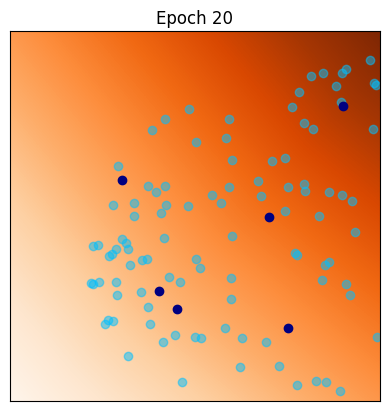

 21%|█████████████████▌                                                                 | 21/99 [01:33<05:56,  4.56s/it]

[21/100] 	Loss_D: 0.0025	Loss_G: -0.0739


 22%|██████████████████▍                                                                | 22/99 [01:37<05:49,  4.55s/it]

[22/100] 	Loss_D: -0.0041	Loss_G: 0.0163


 23%|███████████████████▎                                                               | 23/99 [01:41<05:39,  4.47s/it]

[23/100] 	Loss_D: -0.0035	Loss_G: 0.0028


 24%|████████████████████                                                               | 24/99 [01:46<05:32,  4.43s/it]

[24/100] 	Loss_D: -0.0038	Loss_G: -0.0446


 25%|████████████████████▉                                                              | 25/99 [01:50<05:28,  4.44s/it]

[25/100] 	Loss_D: 0.0014	Loss_G: -0.0577


 26%|█████████████████████▊                                                             | 26/99 [01:55<05:25,  4.46s/it]

[26/100] 	Loss_D: -0.0064	Loss_G: -0.0672


 27%|██████████████████████▋                                                            | 27/99 [01:59<05:21,  4.46s/it]

[27/100] 	Loss_D: -0.0033	Loss_G: -0.0427


 28%|███████████████████████▍                                                           | 28/99 [02:04<05:13,  4.42s/it]

[28/100] 	Loss_D: -0.0008	Loss_G: 0.0020


 29%|████████████████████████▎                                                          | 29/99 [02:08<05:06,  4.38s/it]

[29/100] 	Loss_D: -0.0042	Loss_G: -0.0210
[30/100] 	Loss_D: -0.0006	Loss_G: -0.0700


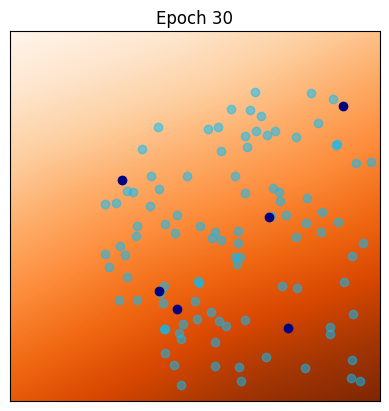

 31%|█████████████████████████▉                                                         | 31/99 [02:17<04:58,  4.39s/it]

[31/100] 	Loss_D: -0.0024	Loss_G: -0.0044


 32%|██████████████████████████▊                                                        | 32/99 [02:21<04:53,  4.37s/it]

[32/100] 	Loss_D: -0.0014	Loss_G: 0.0110


 33%|███████████████████████████▋                                                       | 33/99 [02:25<04:46,  4.34s/it]

[33/100] 	Loss_D: -0.0040	Loss_G: 0.0060


 34%|████████████████████████████▌                                                      | 34/99 [02:30<04:41,  4.33s/it]

[34/100] 	Loss_D: -0.0043	Loss_G: -0.1274


 35%|█████████████████████████████▎                                                     | 35/99 [02:34<04:36,  4.32s/it]

[35/100] 	Loss_D: -0.0030	Loss_G: -0.1364


 36%|██████████████████████████████▏                                                    | 36/99 [02:38<04:31,  4.31s/it]

[36/100] 	Loss_D: -0.0036	Loss_G: 0.0391


 37%|███████████████████████████████                                                    | 37/99 [02:43<04:27,  4.31s/it]

[37/100] 	Loss_D: 0.0002	Loss_G: 0.0330


 38%|███████████████████████████████▊                                                   | 38/99 [02:47<04:22,  4.30s/it]

[38/100] 	Loss_D: -0.0088	Loss_G: 0.0021


 39%|████████████████████████████████▋                                                  | 39/99 [02:51<04:22,  4.38s/it]

[39/100] 	Loss_D: 0.0014	Loss_G: -0.0108
[40/100] 	Loss_D: -0.0051	Loss_G: -0.0239


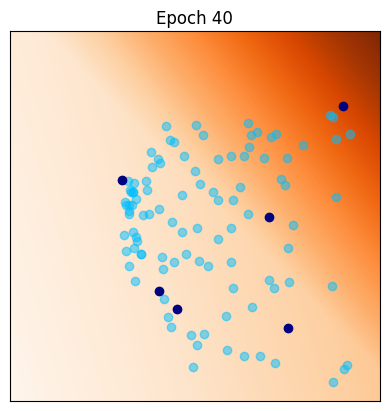

 41%|██████████████████████████████████▎                                                | 41/99 [03:00<04:16,  4.42s/it]

[41/100] 	Loss_D: -0.0080	Loss_G: -0.0225


 42%|███████████████████████████████████▏                                               | 42/99 [03:05<04:12,  4.43s/it]

[42/100] 	Loss_D: -0.0042	Loss_G: -0.0257


 43%|████████████████████████████████████                                               | 43/99 [03:09<04:10,  4.47s/it]

[43/100] 	Loss_D: -0.0012	Loss_G: -0.0168


 44%|████████████████████████████████████▉                                              | 44/99 [03:14<04:09,  4.53s/it]

[44/100] 	Loss_D: -0.0015	Loss_G: -0.0110


 45%|█████████████████████████████████████▋                                             | 45/99 [03:19<04:10,  4.63s/it]

[45/100] 	Loss_D: -0.0040	Loss_G: 0.0134


 46%|██████████████████████████████████████▌                                            | 46/99 [03:24<04:05,  4.63s/it]

[46/100] 	Loss_D: 0.0000	Loss_G: 0.0131


 47%|███████████████████████████████████████▍                                           | 47/99 [03:28<04:05,  4.73s/it]

[47/100] 	Loss_D: -0.0000	Loss_G: -0.0076


 48%|████████████████████████████████████████▏                                          | 48/99 [03:33<04:04,  4.79s/it]

[48/100] 	Loss_D: 0.0006	Loss_G: -0.0019


 49%|█████████████████████████████████████████                                          | 49/99 [03:38<03:54,  4.69s/it]

[49/100] 	Loss_D: -0.0028	Loss_G: 0.0174
[50/100] 	Loss_D: -0.0003	Loss_G: 0.0484


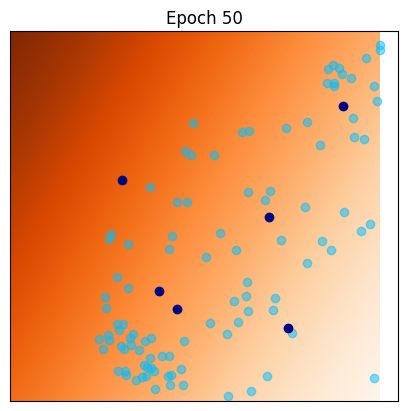

 52%|██████████████████████████████████████████▊                                        | 51/99 [03:47<03:43,  4.66s/it]

[51/100] 	Loss_D: 0.0009	Loss_G: 0.0313


 53%|███████████████████████████████████████████▌                                       | 52/99 [03:52<03:41,  4.72s/it]

[52/100] 	Loss_D: -0.0004	Loss_G: 0.0360


 54%|████████████████████████████████████████████▍                                      | 53/99 [03:57<03:36,  4.70s/it]

[53/100] 	Loss_D: 0.0000	Loss_G: 0.0997


 55%|█████████████████████████████████████████████▎                                     | 54/99 [04:01<03:27,  4.61s/it]

[54/100] 	Loss_D: -0.0019	Loss_G: 0.1918


 56%|██████████████████████████████████████████████                                     | 55/99 [04:06<03:21,  4.58s/it]

[55/100] 	Loss_D: -0.0005	Loss_G: 0.1854


 57%|██████████████████████████████████████████████▉                                    | 56/99 [04:10<03:14,  4.52s/it]

[56/100] 	Loss_D: -0.0014	Loss_G: 0.1735


 58%|███████████████████████████████████████████████▊                                   | 57/99 [04:14<03:10,  4.53s/it]

[57/100] 	Loss_D: -0.0151	Loss_G: 0.2257


 59%|████████████████████████████████████████████████▋                                  | 58/99 [04:19<03:06,  4.55s/it]

[58/100] 	Loss_D: -0.0037	Loss_G: 0.2119


 60%|█████████████████████████████████████████████████▍                                 | 59/99 [04:24<03:01,  4.53s/it]

[59/100] 	Loss_D: -0.0066	Loss_G: 0.0164
[60/100] 	Loss_D: -0.0087	Loss_G: 0.0155


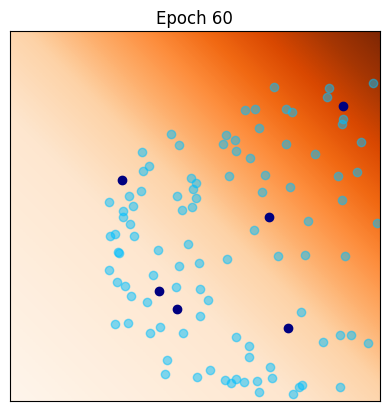

 62%|███████████████████████████████████████████████████▏                               | 61/99 [04:33<02:56,  4.66s/it]

[61/100] 	Loss_D: -0.0009	Loss_G: -0.0036


 63%|███████████████████████████████████████████████████▉                               | 62/99 [04:38<02:53,  4.68s/it]

[62/100] 	Loss_D: -0.0005	Loss_G: 0.0096


 64%|████████████████████████████████████████████████████▊                              | 63/99 [04:42<02:47,  4.66s/it]

[63/100] 	Loss_D: -0.0114	Loss_G: 0.0070


 65%|█████████████████████████████████████████████████████▋                             | 64/99 [04:47<02:40,  4.59s/it]

[64/100] 	Loss_D: 0.0005	Loss_G: -0.0448


 66%|██████████████████████████████████████████████████████▍                            | 65/99 [04:51<02:34,  4.54s/it]

[65/100] 	Loss_D: -0.0023	Loss_G: -0.0006


 67%|███████████████████████████████████████████████████████▎                           | 66/99 [04:56<02:28,  4.51s/it]

[66/100] 	Loss_D: -0.0040	Loss_G: 0.0214


 68%|████████████████████████████████████████████████████████▏                          | 67/99 [05:00<02:24,  4.52s/it]

[67/100] 	Loss_D: -0.0023	Loss_G: 0.0590


 69%|█████████████████████████████████████████████████████████                          | 68/99 [05:05<02:19,  4.50s/it]

[68/100] 	Loss_D: -0.0008	Loss_G: -0.0153


 70%|█████████████████████████████████████████████████████████▊                         | 69/99 [05:09<02:14,  4.48s/it]

[69/100] 	Loss_D: -0.0030	Loss_G: -0.0581
[70/100] 	Loss_D: -0.0007	Loss_G: -0.0037


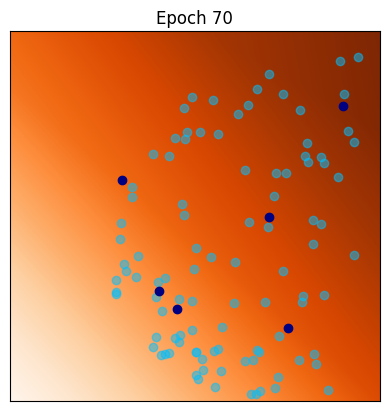

 72%|███████████████████████████████████████████████████████████▌                       | 71/99 [05:19<02:08,  4.60s/it]

[71/100] 	Loss_D: -0.0024	Loss_G: -0.0119


 73%|████████████████████████████████████████████████████████████▎                      | 72/99 [05:23<02:01,  4.51s/it]

[72/100] 	Loss_D: -0.0015	Loss_G: 0.0270


 74%|█████████████████████████████████████████████████████████████▏                     | 73/99 [05:27<01:55,  4.45s/it]

[73/100] 	Loss_D: -0.0007	Loss_G: 0.0322


 75%|██████████████████████████████████████████████████████████████                     | 74/99 [05:32<01:54,  4.56s/it]

[74/100] 	Loss_D: -0.0035	Loss_G: -0.0575


 76%|██████████████████████████████████████████████████████████████▉                    | 75/99 [05:37<01:48,  4.53s/it]

[75/100] 	Loss_D: -0.0001	Loss_G: 0.0684


 77%|███████████████████████████████████████████████████████████████▋                   | 76/99 [05:41<01:43,  4.51s/it]

[76/100] 	Loss_D: -0.0005	Loss_G: 0.0539


 78%|████████████████████████████████████████████████████████████████▌                  | 77/99 [05:45<01:38,  4.49s/it]

[77/100] 	Loss_D: 0.0003	Loss_G: 0.0028


 79%|█████████████████████████████████████████████████████████████████▍                 | 78/99 [05:50<01:34,  4.50s/it]

[78/100] 	Loss_D: -0.0000	Loss_G: 0.0016


 80%|██████████████████████████████████████████████████████████████████▏                | 79/99 [05:55<01:31,  4.56s/it]

[79/100] 	Loss_D: -0.0022	Loss_G: -0.0312
[80/100] 	Loss_D: -0.0029	Loss_G: 0.0359


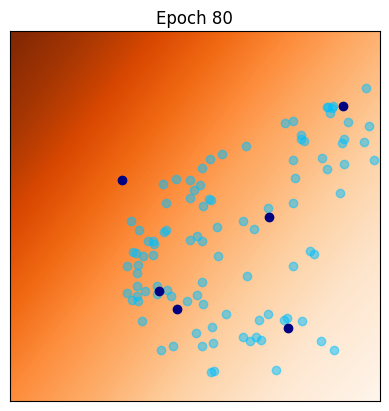

 82%|███████████████████████████████████████████████████████████████████▉               | 81/99 [06:04<01:23,  4.66s/it]

[81/100] 	Loss_D: -0.0029	Loss_G: 0.0103


 83%|████████████████████████████████████████████████████████████████████▋              | 82/99 [06:09<01:18,  4.61s/it]

[82/100] 	Loss_D: -0.0025	Loss_G: -0.0466


 84%|█████████████████████████████████████████████████████████████████████▌             | 83/99 [06:13<01:13,  4.59s/it]

[83/100] 	Loss_D: -0.0015	Loss_G: -0.0456


 85%|██████████████████████████████████████████████████████████████████████▍            | 84/99 [06:18<01:08,  4.57s/it]

[84/100] 	Loss_D: 0.0008	Loss_G: -0.0080


 86%|███████████████████████████████████████████████████████████████████████▎           | 85/99 [06:22<01:03,  4.54s/it]

[85/100] 	Loss_D: -0.0022	Loss_G: 0.0322


 87%|████████████████████████████████████████████████████████████████████████           | 86/99 [06:27<00:58,  4.51s/it]

[86/100] 	Loss_D: -0.0040	Loss_G: 0.0173


 88%|████████████████████████████████████████████████████████████████████████▉          | 87/99 [06:31<00:53,  4.50s/it]

[87/100] 	Loss_D: -0.0066	Loss_G: -0.0263


 89%|█████████████████████████████████████████████████████████████████████████▊         | 88/99 [06:36<00:49,  4.49s/it]

[88/100] 	Loss_D: -0.0020	Loss_G: 0.0572


 90%|██████████████████████████████████████████████████████████████████████████▌        | 89/99 [06:40<00:46,  4.61s/it]

[89/100] 	Loss_D: -0.0025	Loss_G: 0.0173
[90/100] 	Loss_D: -0.0025	Loss_G: 0.0143


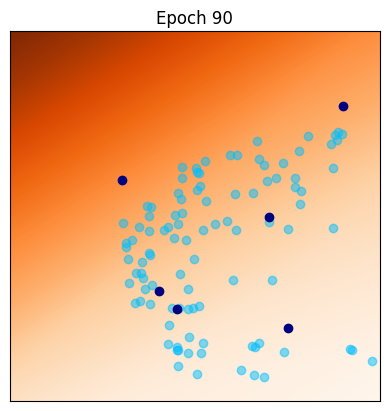

 92%|████████████████████████████████████████████████████████████████████████████▎      | 91/99 [06:50<00:37,  4.64s/it]

[91/100] 	Loss_D: 0.0015	Loss_G: -0.0114


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 92/99 [06:54<00:32,  4.63s/it]

[92/100] 	Loss_D: -0.0038	Loss_G: -0.0418


 94%|█████████████████████████████████████████████████████████████████████████████▉     | 93/99 [06:59<00:27,  4.58s/it]

[93/100] 	Loss_D: -0.0025	Loss_G: -0.0420


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 94/99 [07:03<00:22,  4.54s/it]

[94/100] 	Loss_D: -0.0012	Loss_G: 0.0081


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 95/99 [07:08<00:18,  4.51s/it]

[95/100] 	Loss_D: -0.0017	Loss_G: 0.0300


 97%|████████████████████████████████████████████████████████████████████████████████▍  | 96/99 [07:13<00:13,  4.57s/it]

[96/100] 	Loss_D: -0.0037	Loss_G: 0.0393


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 97/99 [07:17<00:09,  4.53s/it]

[97/100] 	Loss_D: -0.0024	Loss_G: 0.0230


 99%|██████████████████████████████████████████████████████████████████████████████████▏| 98/99 [07:21<00:04,  4.52s/it]

[98/100] 	Loss_D: -0.0041	Loss_G: 0.0127


100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [07:26<00:00,  4.51s/it]

[99/100] 	Loss_D: -0.0043	Loss_G: 0.0117


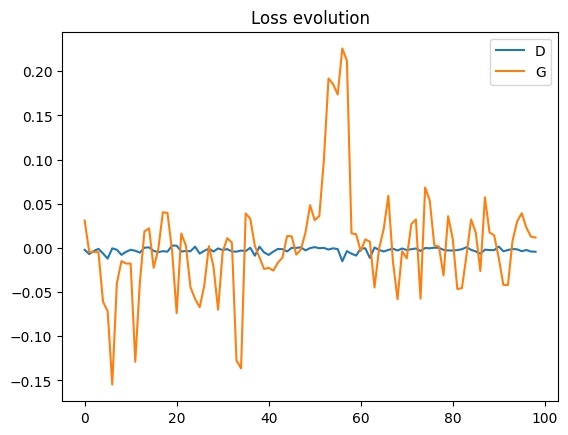

<All keys matched successfully>

In [39]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generator and discriminator
### ... ###

optimG = optim.Adam(G.parameters(), lr=lr)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

clip_value = .1
iter_display = 10

# Main loop
for epoch in tqdm(range(1,n_epochs)):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        optimD.zero_grad()
        z = torch.randn(b, n_in).to(device)
        g_z = G(z).detach()
        ### UPDATE OF D ###
        Dloss = -torch.mean(D(y)) + torch.mean(D(g_z))
        Dloss.backward()
        optimD.step()
        ### ... (weight clipping step) ... ###
        for param in D.parameters():
            param.data.clamp_(-clip_value, clip_value)

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()
        z = torch.randn(b, n_in, device = device)
        g_z = G(z)
        Gloss = - torch.mean(D(g_z))
        Gloss.backward()
        optimG.step()


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

# Save final generator for later use
wganwc = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wganwc.load_state_dict(G.state_dict())

## Estimate the Lipschitz constant of the discriminator

QUESTION: Implement a function computing an estimation of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

Use this function to examine the Lipschitz constant of the final discriminator obtained with WGAN-WC.

In [98]:
def lipconstant(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()
    # Calculate discriminator on interpolated examples
    Di = D(interp).view(-1)
    gradout = torch.ones(Di.size(), device=  device)
    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(Di,  interp, gradout, retain_graph = True, create_graph = True)[0]


    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim = 1) + 1e-12)

    # Return gradient penalty
    return torch.mean(gradients_norm)

#### (lip constant of the current D) ###

## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of $D$ on points that are interpolated between $x$ and $y$.

In [101]:
def gradient_penalty(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    #### ... ###
        # Calculate discriminator on interpolated examples
    Di = D(interp).view(-1)
    gradout = torch.ones(Di.size(), device=  device)
    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(Di,  interp, gradout, retain_graph = True, create_graph = True)[0]


    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim = 1) + 1e-12)

    # Return gradient penalty
    return torch.mean((gradients_norm - 1) ** 2)



## Train the WGAN-GP discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\leq 1$.

How would you judge the resulting discriminator?

[0/1000], -0.572843


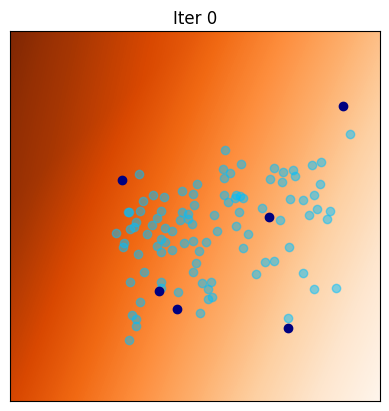

[100/1000], -0.032926


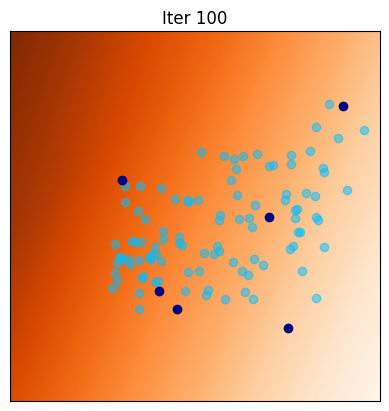

[200/1000], -0.052361


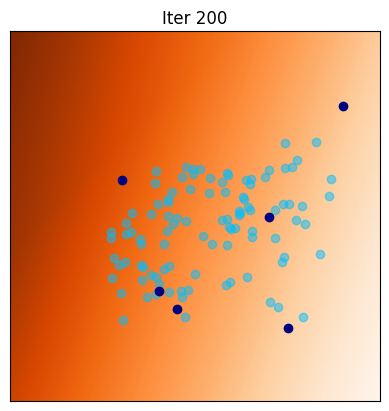

[300/1000], -0.049945


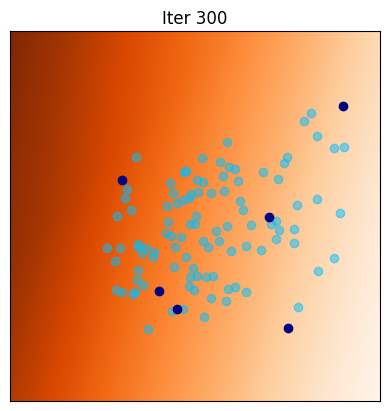

[400/1000], -0.048199


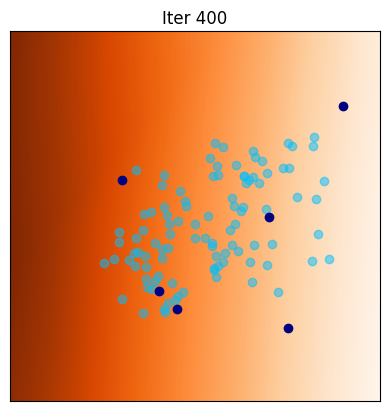

[500/1000], -0.028856


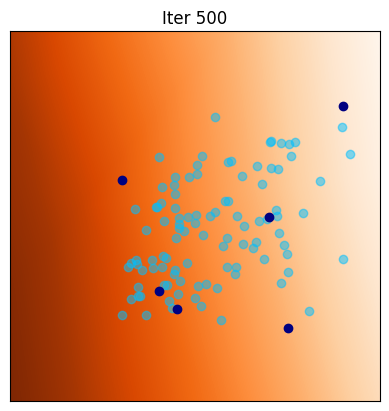

[600/1000], 0.006691


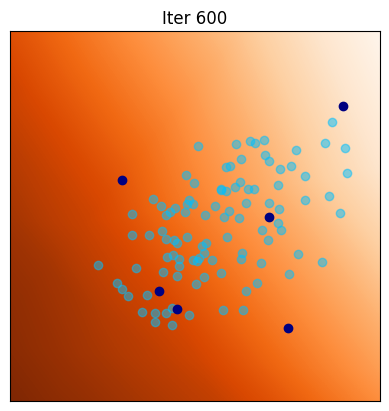

[700/1000], 0.018391


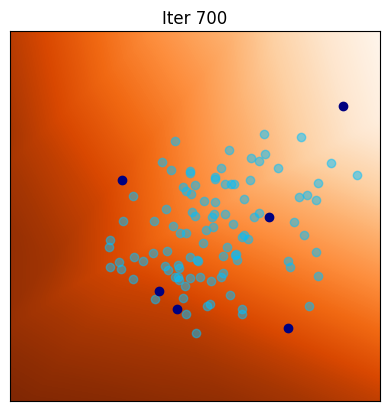

[800/1000], 0.041511


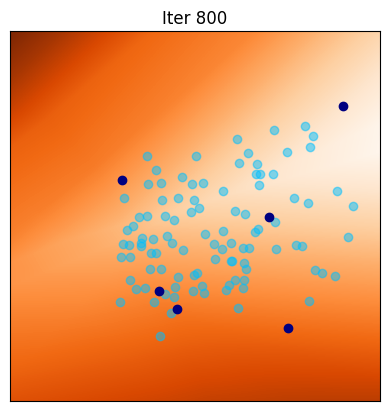

[900/1000], 0.074490


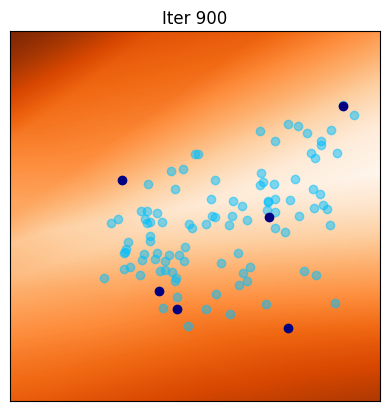

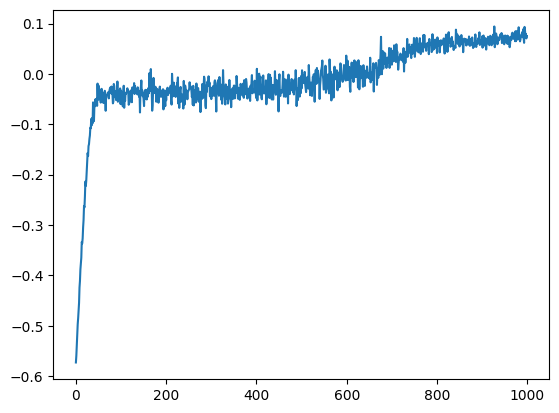

In [111]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Reinitialize generators and discriminators
G = Generator(n_in = n_in, n_out = 2, n_hid = 10, nlayers = 3, device = device)

D = DWGAN(n_in = d, n_hid = 10).to(device)
optimG = optim.Adam(G.parameters(), lr=lr)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 1
niterD=1000

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    optimD.zero_grad()
    z = torch.randn(b, n_in, device = device)
    g_z = G(z).detach()
    ### UPDATE OF D ###
    gp = gradient_penalty(D,y,g_z)
    Dloss = -torch.mean(D(y)) + torch.mean(D(g_z)) + gpw * gp
    Dloss.backward()
    optimD.step()
    ### SAVE LOSS ###
    Dlosst = -Dloss.item()
    Dlosses.append(Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([]) 
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

Final estimated Lipschitz constant =  1.0276424884796143


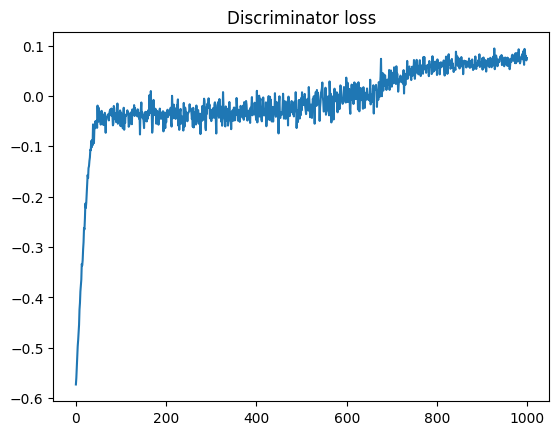

In [112]:
print('Final estimated Lipschitz constant = ',lipconstant(D,y, g_z).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

QUESTION: Learn both generator and discriminator with the gradient penalty term

  1%|▊                                                                                   | 1/99 [00:00<01:18,  1.25it/s]

[1/100] 	Loss_D: 0.0307	Loss_G: 1.2153


  2%|█▋                                                                                  | 2/99 [00:01<01:14,  1.31it/s]

[2/100] 	Loss_D: -0.2286	Loss_G: 0.1716


  3%|██▌                                                                                 | 3/99 [00:02<01:12,  1.32it/s]

[3/100] 	Loss_D: -0.1639	Loss_G: -0.0198


  4%|███▍                                                                                | 4/99 [00:03<01:11,  1.33it/s]

[4/100] 	Loss_D: -0.0175	Loss_G: -0.1663
[5/100] 	Loss_D: -0.0342	Loss_G: 0.2676


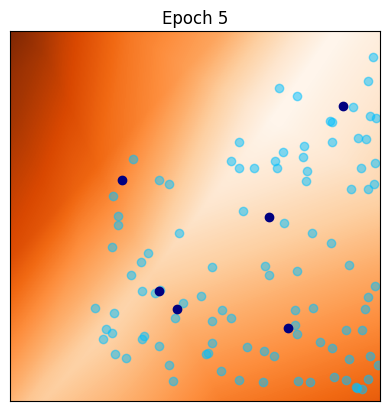

  6%|█████                                                                               | 6/99 [00:04<01:14,  1.25it/s]

[6/100] 	Loss_D: -0.1246	Loss_G: 0.8600


  7%|█████▉                                                                              | 7/99 [00:05<01:12,  1.27it/s]

[7/100] 	Loss_D: -0.1658	Loss_G: 0.6785


  8%|██████▊                                                                             | 8/99 [00:06<01:11,  1.28it/s]

[8/100] 	Loss_D: -0.1164	Loss_G: 0.3826


  9%|███████▋                                                                            | 9/99 [00:07<01:09,  1.29it/s]

[9/100] 	Loss_D: -0.0765	Loss_G: -0.2357
[10/100] 	Loss_D: -0.1206	Loss_G: -1.2730


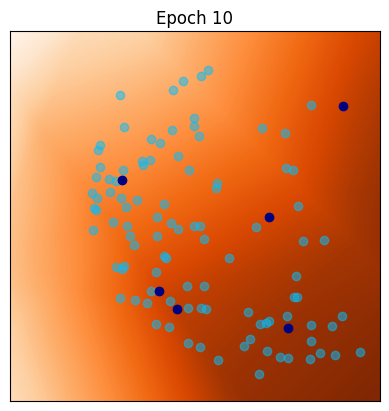

 11%|█████████▏                                                                         | 11/99 [00:08<01:11,  1.23it/s]

[11/100] 	Loss_D: -0.0823	Loss_G: -1.4909


 12%|██████████                                                                         | 12/99 [00:09<01:10,  1.23it/s]

[12/100] 	Loss_D: -0.1036	Loss_G: -1.2137


 13%|██████████▉                                                                        | 13/99 [00:10<01:09,  1.25it/s]

[13/100] 	Loss_D: -0.0470	Loss_G: -0.5872


 14%|███████████▋                                                                       | 14/99 [00:11<01:07,  1.27it/s]

[14/100] 	Loss_D: -0.1120	Loss_G: -0.6842
[15/100] 	Loss_D: -0.1137	Loss_G: -1.1820


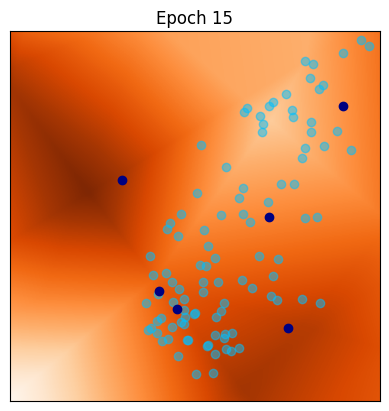

 16%|█████████████▍                                                                     | 16/99 [00:12<01:08,  1.22it/s]

[16/100] 	Loss_D: -0.1122	Loss_G: -1.8767


 17%|██████████████▎                                                                    | 17/99 [00:13<01:06,  1.24it/s]

[17/100] 	Loss_D: -0.1022	Loss_G: -1.8644


 18%|███████████████                                                                    | 18/99 [00:14<01:05,  1.24it/s]

[18/100] 	Loss_D: -0.0569	Loss_G: -1.6562


 19%|███████████████▉                                                                   | 19/99 [00:15<01:04,  1.25it/s]

[19/100] 	Loss_D: -0.1795	Loss_G: -1.3070
[20/100] 	Loss_D: -0.1380	Loss_G: -1.6246


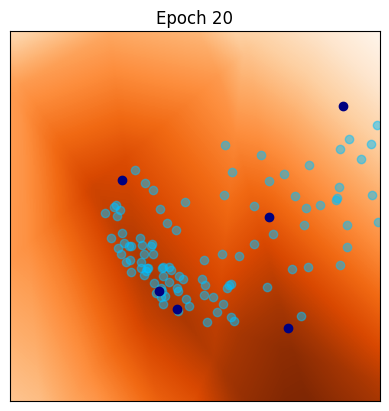

 21%|█████████████████▌                                                                 | 21/99 [00:16<01:04,  1.21it/s]

[21/100] 	Loss_D: -0.0581	Loss_G: -1.7996


 22%|██████████████████▍                                                                | 22/99 [00:17<01:01,  1.24it/s]

[22/100] 	Loss_D: -0.1304	Loss_G: -1.9441


 23%|███████████████████▎                                                               | 23/99 [00:18<01:01,  1.24it/s]

[23/100] 	Loss_D: -0.0858	Loss_G: -2.0457


 24%|████████████████████                                                               | 24/99 [00:19<01:00,  1.24it/s]

[24/100] 	Loss_D: -0.0859	Loss_G: -1.8194
[25/100] 	Loss_D: -0.0686	Loss_G: -1.5873


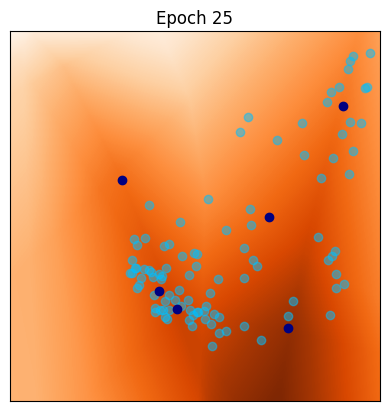

 26%|█████████████████████▊                                                             | 26/99 [00:21<01:01,  1.19it/s]

[26/100] 	Loss_D: -0.0808	Loss_G: -1.5712


 27%|██████████████████████▋                                                            | 27/99 [00:21<01:00,  1.19it/s]

[27/100] 	Loss_D: -0.0579	Loss_G: -1.8766


 28%|███████████████████████▍                                                           | 28/99 [00:22<00:59,  1.19it/s]

[28/100] 	Loss_D: -0.0724	Loss_G: -2.0366


 29%|████████████████████████▎                                                          | 29/99 [00:23<00:58,  1.20it/s]

[29/100] 	Loss_D: -0.0781	Loss_G: -2.2557
[30/100] 	Loss_D: -0.0621	Loss_G: -2.3645


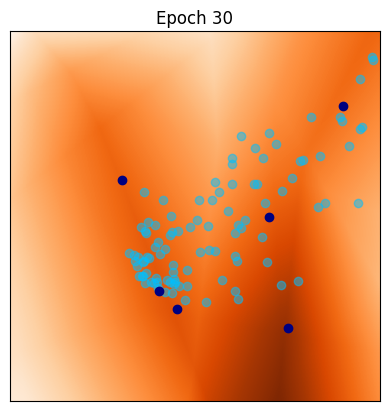

 31%|█████████████████████████▉                                                         | 31/99 [00:25<00:57,  1.18it/s]

[31/100] 	Loss_D: -0.0867	Loss_G: -2.2878


 32%|██████████████████████████▊                                                        | 32/99 [00:26<00:55,  1.20it/s]

[32/100] 	Loss_D: -0.0896	Loss_G: -2.3820


 33%|███████████████████████████▋                                                       | 33/99 [00:26<00:54,  1.20it/s]

[33/100] 	Loss_D: -0.0760	Loss_G: -2.7471


 34%|████████████████████████████▌                                                      | 34/99 [00:27<00:54,  1.20it/s]

[34/100] 	Loss_D: -0.0733	Loss_G: -2.8889
[35/100] 	Loss_D: -0.0647	Loss_G: -2.7344


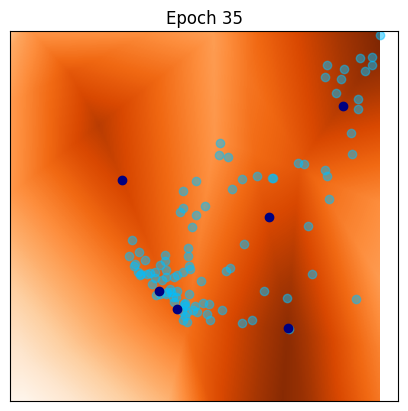

 36%|██████████████████████████████▏                                                    | 36/99 [00:29<00:54,  1.17it/s]

[36/100] 	Loss_D: -0.0973	Loss_G: -2.4840


 37%|███████████████████████████████                                                    | 37/99 [00:30<00:52,  1.19it/s]

[37/100] 	Loss_D: -0.0752	Loss_G: -2.4786


 38%|███████████████████████████████▊                                                   | 38/99 [00:31<00:51,  1.19it/s]

[38/100] 	Loss_D: -0.1043	Loss_G: -2.8392


 39%|████████████████████████████████▋                                                  | 39/99 [00:31<00:49,  1.20it/s]

[39/100] 	Loss_D: -0.0779	Loss_G: -2.8634
[40/100] 	Loss_D: -0.0677	Loss_G: -2.7112


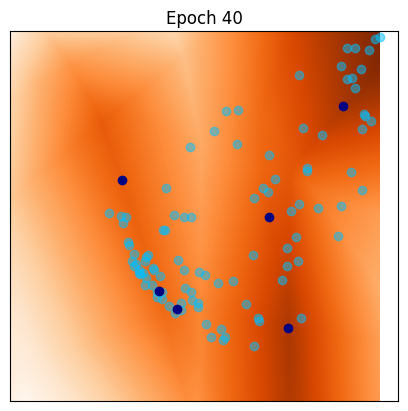

 41%|██████████████████████████████████▎                                                | 41/99 [00:33<00:48,  1.20it/s]

[41/100] 	Loss_D: -0.1202	Loss_G: -2.2996


 42%|███████████████████████████████████▏                                               | 42/99 [00:34<00:48,  1.18it/s]

[42/100] 	Loss_D: -0.0728	Loss_G: -2.1707


 43%|████████████████████████████████████                                               | 43/99 [00:35<00:48,  1.16it/s]

[43/100] 	Loss_D: -0.0686	Loss_G: -2.3279


 44%|████████████████████████████████████▉                                              | 44/99 [00:36<00:46,  1.17it/s]

[44/100] 	Loss_D: -0.0849	Loss_G: -2.7861
[45/100] 	Loss_D: -0.0620	Loss_G: -2.7502


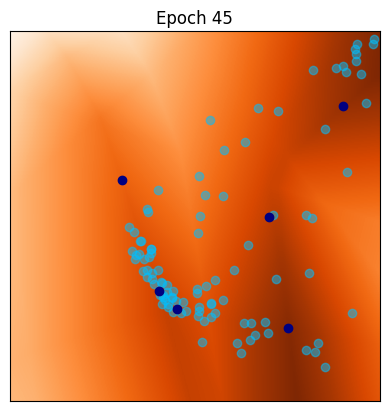

 46%|██████████████████████████████████████▌                                            | 46/99 [00:38<00:46,  1.13it/s]

[46/100] 	Loss_D: -0.0814	Loss_G: -2.2752


 47%|███████████████████████████████████████▍                                           | 47/99 [00:38<00:45,  1.14it/s]

[47/100] 	Loss_D: -0.0863	Loss_G: -1.9425


 48%|████████████████████████████████████████▏                                          | 48/99 [00:39<00:44,  1.14it/s]

[48/100] 	Loss_D: -0.0663	Loss_G: -1.9799


 49%|█████████████████████████████████████████                                          | 49/99 [00:40<00:43,  1.16it/s]

[49/100] 	Loss_D: -0.0855	Loss_G: -2.4241
[50/100] 	Loss_D: -0.1291	Loss_G: -2.9022


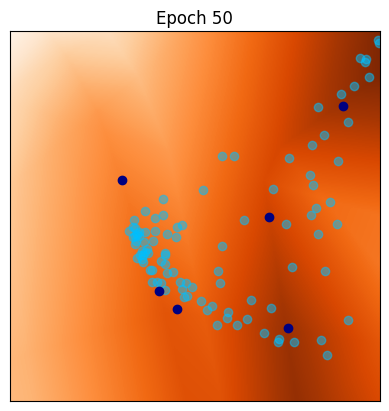

 52%|██████████████████████████████████████████▊                                        | 51/99 [00:42<00:42,  1.14it/s]

[51/100] 	Loss_D: -0.0700	Loss_G: -2.5853


 53%|███████████████████████████████████████████▌                                       | 52/99 [00:43<00:40,  1.15it/s]

[52/100] 	Loss_D: -0.0719	Loss_G: -1.9709


 54%|████████████████████████████████████████████▍                                      | 53/99 [00:44<00:39,  1.17it/s]

[53/100] 	Loss_D: -0.0623	Loss_G: -1.6873


 55%|█████████████████████████████████████████████▎                                     | 54/99 [00:45<00:38,  1.16it/s]

[54/100] 	Loss_D: -0.0658	Loss_G: -1.7490
[55/100] 	Loss_D: -0.0835	Loss_G: -2.3745


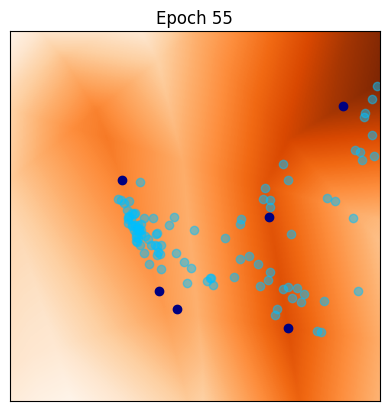

 57%|██████████████████████████████████████████████▉                                    | 56/99 [00:46<00:37,  1.14it/s]

[56/100] 	Loss_D: -0.1062	Loss_G: -2.8486


 58%|███████████████████████████████████████████████▊                                   | 57/99 [00:47<00:35,  1.17it/s]

[57/100] 	Loss_D: -0.0653	Loss_G: -2.5485


 59%|████████████████████████████████████████████████▋                                  | 58/99 [00:48<00:34,  1.19it/s]

[58/100] 	Loss_D: -0.0705	Loss_G: -2.0278


 60%|█████████████████████████████████████████████████▍                                 | 59/99 [00:49<00:33,  1.19it/s]

[59/100] 	Loss_D: -0.0989	Loss_G: -1.6321
[60/100] 	Loss_D: -0.0787	Loss_G: -1.6724


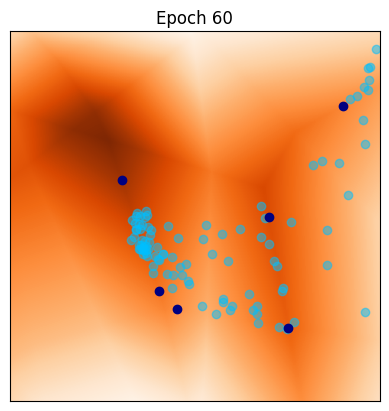

 62%|███████████████████████████████████████████████████▏                               | 61/99 [00:51<00:31,  1.20it/s]

[61/100] 	Loss_D: -0.0575	Loss_G: -2.1745


 63%|███████████████████████████████████████████████████▉                               | 62/99 [00:51<00:30,  1.23it/s]

[62/100] 	Loss_D: -0.0961	Loss_G: -2.6779


 64%|████████████████████████████████████████████████████▊                              | 63/99 [00:52<00:28,  1.26it/s]

[63/100] 	Loss_D: -0.0724	Loss_G: -2.7018


 65%|█████████████████████████████████████████████████████▋                             | 64/99 [00:53<00:27,  1.28it/s]

[64/100] 	Loss_D: -0.0373	Loss_G: -2.3945
[65/100] 	Loss_D: -0.0715	Loss_G: -1.9058


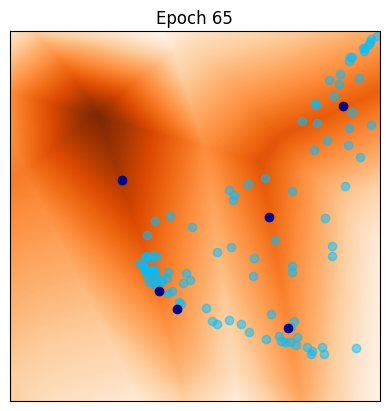

 67%|███████████████████████████████████████████████████████▎                           | 66/99 [00:55<00:28,  1.17it/s]

[66/100] 	Loss_D: -0.0850	Loss_G: -1.6869


 68%|████████████████████████████████████████████████████████▏                          | 67/99 [00:55<00:27,  1.17it/s]

[67/100] 	Loss_D: -0.0529	Loss_G: -1.8799


 69%|█████████████████████████████████████████████████████████                          | 68/99 [00:56<00:25,  1.19it/s]

[68/100] 	Loss_D: -0.0717	Loss_G: -2.3308


 70%|█████████████████████████████████████████████████████████▊                         | 69/99 [00:57<00:25,  1.18it/s]

[69/100] 	Loss_D: -0.0796	Loss_G: -2.5646
[70/100] 	Loss_D: -0.0706	Loss_G: -2.5405


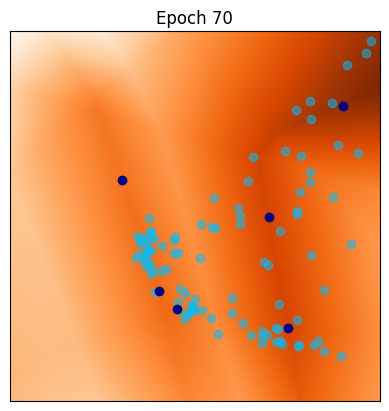

 72%|███████████████████████████████████████████████████████████▌                       | 71/99 [00:59<00:23,  1.20it/s]

[71/100] 	Loss_D: -0.0656	Loss_G: -2.3758


 73%|████████████████████████████████████████████████████████████▎                      | 72/99 [01:00<00:22,  1.21it/s]

[72/100] 	Loss_D: -0.0761	Loss_G: -2.0834


 74%|█████████████████████████████████████████████████████████████▏                     | 73/99 [01:00<00:21,  1.22it/s]

[73/100] 	Loss_D: -0.0496	Loss_G: -2.1695


 75%|██████████████████████████████████████████████████████████████                     | 74/99 [01:01<00:20,  1.22it/s]

[74/100] 	Loss_D: -0.0759	Loss_G: -2.4170
[75/100] 	Loss_D: -0.0813	Loss_G: -2.6376


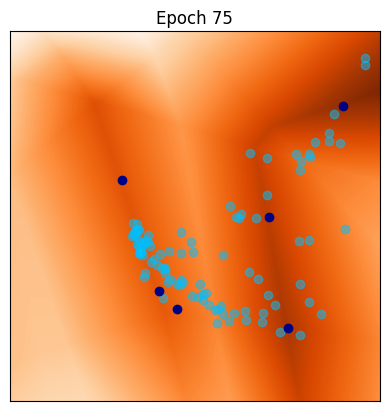

 77%|███████████████████████████████████████████████████████████████▋                   | 76/99 [01:03<00:19,  1.18it/s]

[76/100] 	Loss_D: -0.0542	Loss_G: -2.7042


 78%|████████████████████████████████████████████████████████████████▌                  | 77/99 [01:04<00:18,  1.18it/s]

[77/100] 	Loss_D: -0.0396	Loss_G: -2.6961


 79%|█████████████████████████████████████████████████████████████████▍                 | 78/99 [01:05<00:17,  1.17it/s]

[78/100] 	Loss_D: -0.0377	Loss_G: -2.7316


 80%|██████████████████████████████████████████████████████████████████▏                | 79/99 [01:06<00:17,  1.17it/s]

[79/100] 	Loss_D: -0.0572	Loss_G: -2.7504
[80/100] 	Loss_D: -0.0561	Loss_G: -2.8555


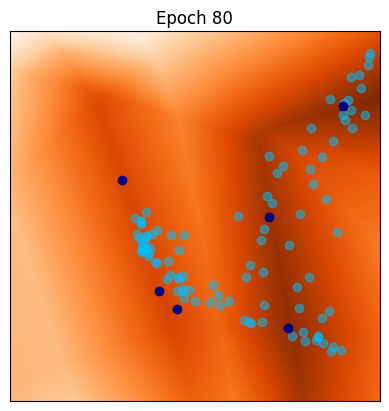

 82%|███████████████████████████████████████████████████████████████████▉               | 81/99 [01:07<00:15,  1.14it/s]

[81/100] 	Loss_D: -0.0641	Loss_G: -2.8484


 83%|████████████████████████████████████████████████████████████████████▋              | 82/99 [01:08<00:14,  1.18it/s]

[82/100] 	Loss_D: -0.0681	Loss_G: -2.8665


 84%|█████████████████████████████████████████████████████████████████████▌             | 83/99 [01:09<00:13,  1.20it/s]

[83/100] 	Loss_D: -0.0586	Loss_G: -2.9758


 85%|██████████████████████████████████████████████████████████████████████▍            | 84/99 [01:10<00:12,  1.20it/s]

[84/100] 	Loss_D: -0.0621	Loss_G: -3.0313
[85/100] 	Loss_D: -0.0621	Loss_G: -3.1174


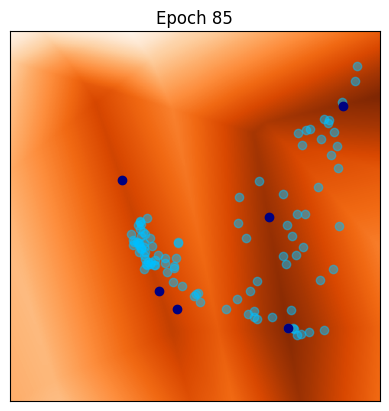

 87%|████████████████████████████████████████████████████████████████████████           | 86/99 [01:12<00:11,  1.12it/s]

[86/100] 	Loss_D: -0.0626	Loss_G: -3.0799


 88%|████████████████████████████████████████████████████████████████████████▉          | 87/99 [01:13<00:10,  1.15it/s]

[87/100] 	Loss_D: -0.0592	Loss_G: -3.1344


 89%|█████████████████████████████████████████████████████████████████████████▊         | 88/99 [01:13<00:09,  1.20it/s]

[88/100] 	Loss_D: -0.0568	Loss_G: -3.2860


 90%|██████████████████████████████████████████████████████████████████████████▌        | 89/99 [01:14<00:08,  1.22it/s]

[89/100] 	Loss_D: -0.0517	Loss_G: -3.4048
[90/100] 	Loss_D: -0.0654	Loss_G: -3.3502


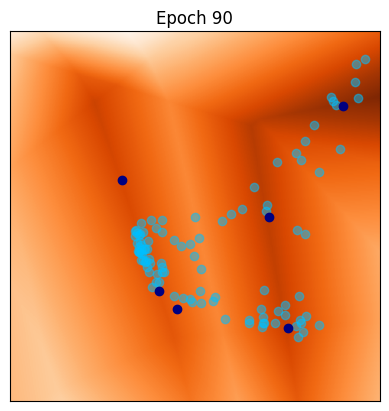

 92%|████████████████████████████████████████████████████████████████████████████▎      | 91/99 [01:16<00:06,  1.18it/s]

[91/100] 	Loss_D: -0.0678	Loss_G: -3.3684


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 92/99 [01:17<00:05,  1.20it/s]

[92/100] 	Loss_D: -0.0616	Loss_G: -3.4737


 94%|█████████████████████████████████████████████████████████████████████████████▉     | 93/99 [01:18<00:05,  1.18it/s]

[93/100] 	Loss_D: -0.0501	Loss_G: -3.5685


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 94/99 [01:18<00:04,  1.18it/s]

[94/100] 	Loss_D: -0.0506	Loss_G: -3.6139
[95/100] 	Loss_D: -0.0733	Loss_G: -3.6789


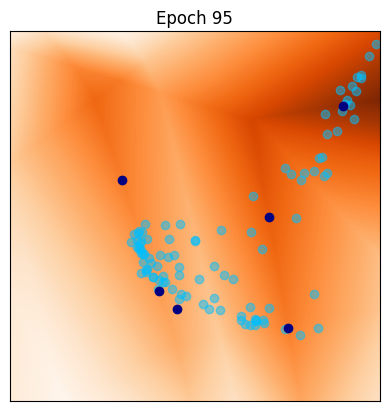

 97%|████████████████████████████████████████████████████████████████████████████████▍  | 96/99 [01:20<00:02,  1.17it/s]

[96/100] 	Loss_D: -0.0503	Loss_G: -3.5966


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 97/99 [01:21<00:01,  1.16it/s]

[97/100] 	Loss_D: -0.0653	Loss_G: -3.7136


 99%|██████████████████████████████████████████████████████████████████████████████████▏| 98/99 [01:22<00:00,  1.18it/s]

[98/100] 	Loss_D: -0.0446	Loss_G: -3.8270


100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [01:23<00:00,  1.19it/s]

[99/100] 	Loss_D: -0.0599	Loss_G: -3.7105


<All keys matched successfully>

In [113]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 0.1
niterD=100

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

#### ... ###
# (adapt the loop written for WGAN-WC)
for epoch in tqdm(range(1,n_epochs)):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        optimD.zero_grad()
        z = torch.randn(b, n_in).to(device)
        g_z = G(z).detach()
        ### UPDATE OF D ###
        gp = gradient_penalty(D,y,g_z)
        Dloss = -torch.mean(D(y)) + torch.mean(D(g_z)) + gpw * gp
        Dloss.backward()
        optimD.step()
        ### ... (weight clipping step) ... ###


    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()
        z = torch.randn(b, n_in, device = device)
        g_z = G(z)
        Gloss = - torch.mean(D(g_z))
        Gloss.backward()
        optimG.step()


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()



# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

<br/><br/><br/><br/>

# Exercise 2: Learn a GAN

## Define Discriminator Architecture

QUESTION: What do you have to change to get a discriminator adapted for GAN training?

The discriminator for the GAN outputs a probability.

We need to add a sigmoid activation for the last layer.

In [7]:
class DGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = nn.Sigmoid()(self.fc3(y))
    return y

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/1000], 1.391300


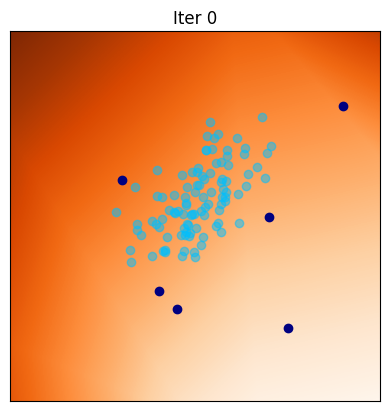

[100/1000], 1.239315


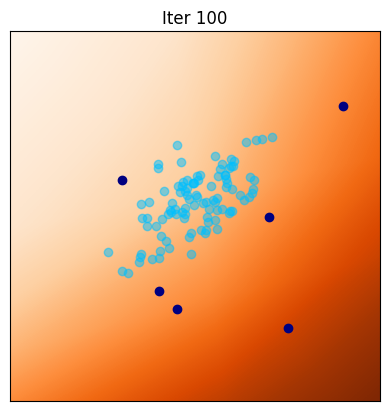

[200/1000], 0.864735


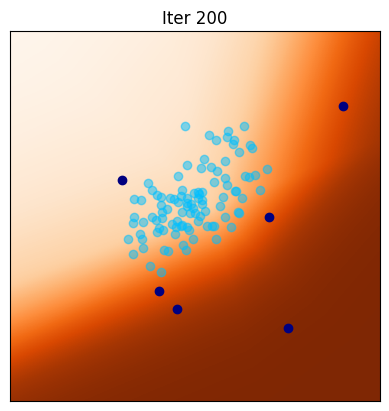

[300/1000], 0.735916


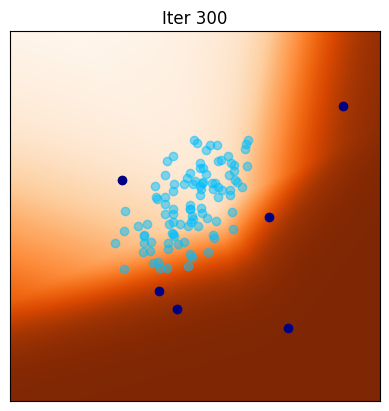

[400/1000], 0.583268


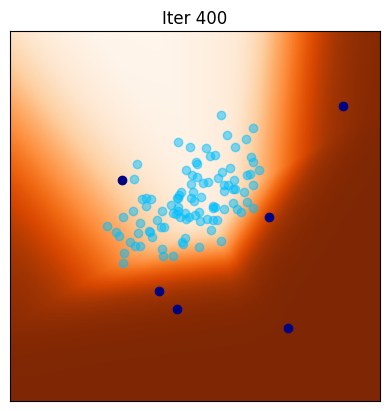

[500/1000], 0.523502


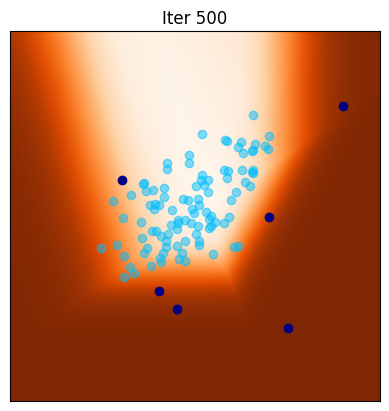

[600/1000], 0.303841


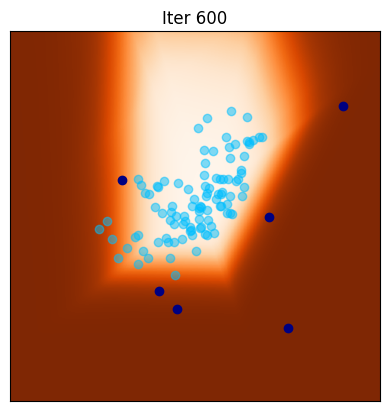

[700/1000], 0.282141


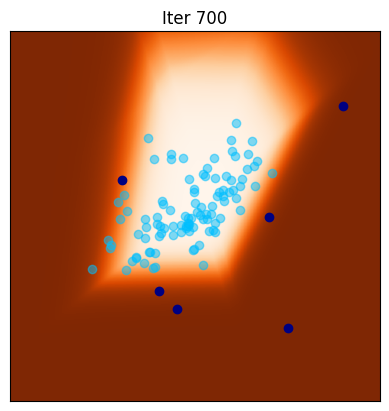

[800/1000], 0.188170


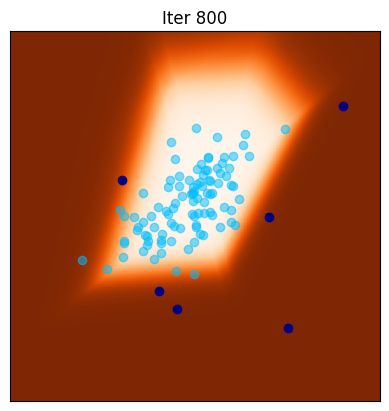

[900/1000], 0.134570


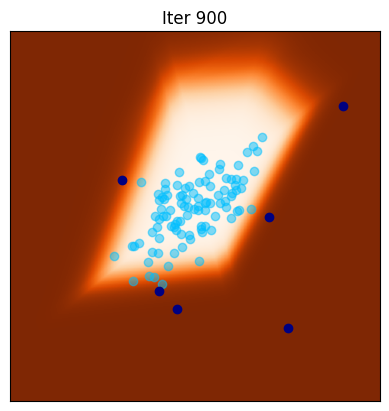

In [8]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

D = DGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    ### ... ###
    z = torch.randn(b, n_in, device = device)
    g_z = G(z).detach()
    Dloss = -torch.mean(torch.log(D(y))) - torch.mean(torch.log(1 - D(g_z)))
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


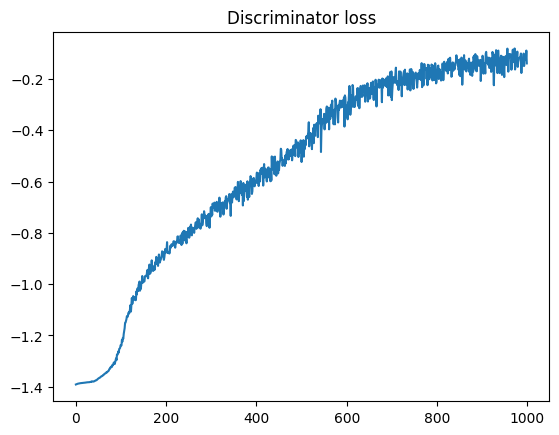

In [9]:
### Plot the evolution of the discriminator loss ###

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 0.9338	Loss_G: 0.8437


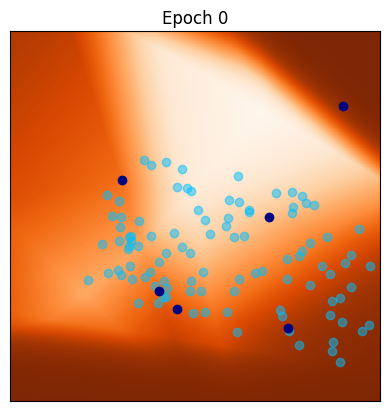

[1/100] 	Loss_D: 0.9285	Loss_G: 1.1055
[2/100] 	Loss_D: 0.9509	Loss_G: 0.9754
[3/100] 	Loss_D: 0.6595	Loss_G: 1.3778
[4/100] 	Loss_D: 0.5593	Loss_G: 1.4230
[5/100] 	Loss_D: 0.4725	Loss_G: 2.2420
[6/100] 	Loss_D: 0.4665	Loss_G: 2.1456
[7/100] 	Loss_D: 0.4352	Loss_G: 2.4492
[8/100] 	Loss_D: 0.3959	Loss_G: 2.7791
[9/100] 	Loss_D: 0.3232	Loss_G: 2.3866
[10/100] 	Loss_D: 0.4281	Loss_G: 1.9062


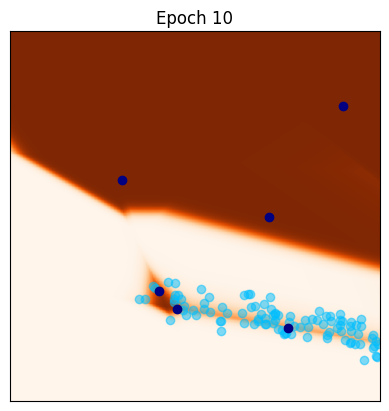

[11/100] 	Loss_D: 0.5683	Loss_G: 1.9695
[12/100] 	Loss_D: 0.5872	Loss_G: 1.9063
[13/100] 	Loss_D: 0.4095	Loss_G: 1.1352
[14/100] 	Loss_D: 0.4225	Loss_G: 0.0747
[15/100] 	Loss_D: 0.1097	Loss_G: 0.8608
[16/100] 	Loss_D: 0.7042	Loss_G: 1.4568
[17/100] 	Loss_D: 0.4944	Loss_G: 1.6172
[18/100] 	Loss_D: 0.2014	Loss_G: 0.5980
[19/100] 	Loss_D: 0.4156	Loss_G: 1.3639
[20/100] 	Loss_D: 0.3815	Loss_G: 1.7267


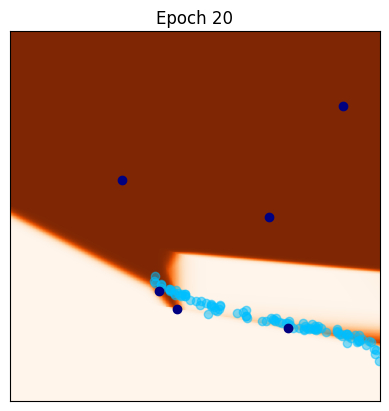

[21/100] 	Loss_D: 0.3021	Loss_G: 1.1464
[22/100] 	Loss_D: 0.3821	Loss_G: 0.6246
[23/100] 	Loss_D: 0.3927	Loss_G: 1.2021
[24/100] 	Loss_D: 0.6381	Loss_G: 1.8259
[25/100] 	Loss_D: 0.5727	Loss_G: 0.9535
[26/100] 	Loss_D: 0.3169	Loss_G: 0.8856
[27/100] 	Loss_D: 0.6745	Loss_G: 1.2524
[28/100] 	Loss_D: 0.3276	Loss_G: 0.9997
[29/100] 	Loss_D: 0.2738	Loss_G: 1.0013
[30/100] 	Loss_D: 0.6976	Loss_G: 1.9760


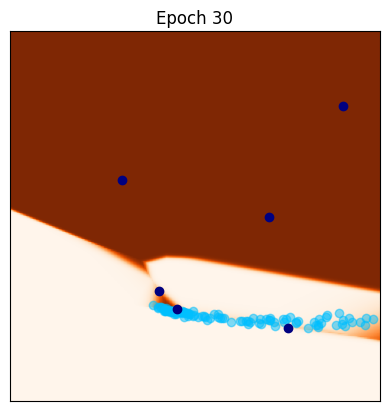

[31/100] 	Loss_D: 0.2061	Loss_G: 0.7780
[32/100] 	Loss_D: 0.2894	Loss_G: 1.1820
[33/100] 	Loss_D: 0.6351	Loss_G: 1.3154
[34/100] 	Loss_D: 0.2621	Loss_G: 0.7357
[35/100] 	Loss_D: 0.3599	Loss_G: 0.1371
[36/100] 	Loss_D: 0.4540	Loss_G: 1.3232
[37/100] 	Loss_D: 0.6256	Loss_G: 1.6459
[38/100] 	Loss_D: 0.6629	Loss_G: 1.6922
[39/100] 	Loss_D: 0.4709	Loss_G: 1.1318
[40/100] 	Loss_D: 0.2369	Loss_G: 1.6034


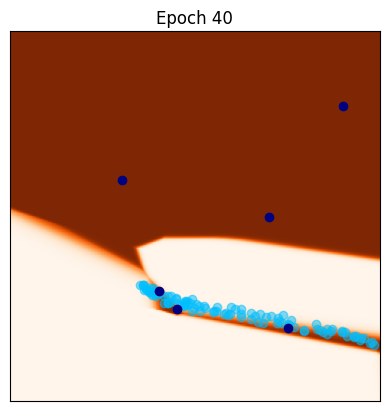

[41/100] 	Loss_D: 0.5985	Loss_G: 1.4929
[42/100] 	Loss_D: 0.5763	Loss_G: 1.7602
[43/100] 	Loss_D: 0.4845	Loss_G: 0.9318
[44/100] 	Loss_D: 0.2063	Loss_G: 0.5370
[45/100] 	Loss_D: 0.4174	Loss_G: 1.6334
[46/100] 	Loss_D: 0.5438	Loss_G: 0.8385
[47/100] 	Loss_D: 0.4536	Loss_G: 1.9198
[48/100] 	Loss_D: 0.3681	Loss_G: 0.7112
[49/100] 	Loss_D: 0.4694	Loss_G: 1.9397
[50/100] 	Loss_D: 0.4955	Loss_G: 1.4650


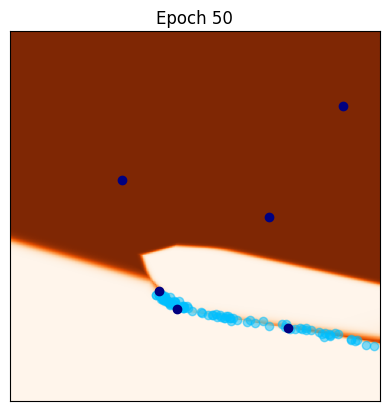

[51/100] 	Loss_D: 0.6800	Loss_G: 2.3716
[52/100] 	Loss_D: 0.5689	Loss_G: 1.4894
[53/100] 	Loss_D: 0.8124	Loss_G: 1.4500
[54/100] 	Loss_D: 0.6318	Loss_G: 1.4744
[55/100] 	Loss_D: 0.6700	Loss_G: 1.6223
[56/100] 	Loss_D: 0.6555	Loss_G: 1.1967
[57/100] 	Loss_D: 0.6801	Loss_G: 1.1096
[58/100] 	Loss_D: 0.7003	Loss_G: 1.5165
[59/100] 	Loss_D: 0.7200	Loss_G: 2.2822
[60/100] 	Loss_D: 0.5842	Loss_G: 0.8613


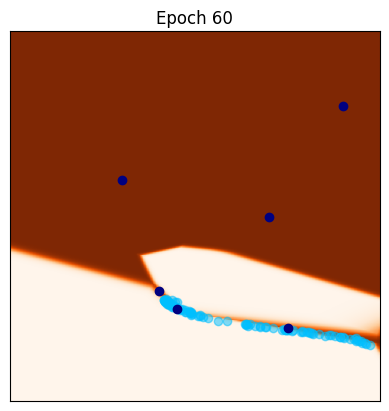

[61/100] 	Loss_D: 0.4780	Loss_G: 2.2717
[62/100] 	Loss_D: 0.4204	Loss_G: 1.0749
[63/100] 	Loss_D: 0.5105	Loss_G: 1.2098
[64/100] 	Loss_D: 0.5511	Loss_G: 0.9731
[65/100] 	Loss_D: 0.4003	Loss_G: 1.5703
[66/100] 	Loss_D: 0.4951	Loss_G: 1.7408
[67/100] 	Loss_D: 0.5420	Loss_G: 1.3071
[68/100] 	Loss_D: 0.6320	Loss_G: 2.8737
[69/100] 	Loss_D: 0.4981	Loss_G: 2.0973
[70/100] 	Loss_D: 0.4522	Loss_G: 2.1031


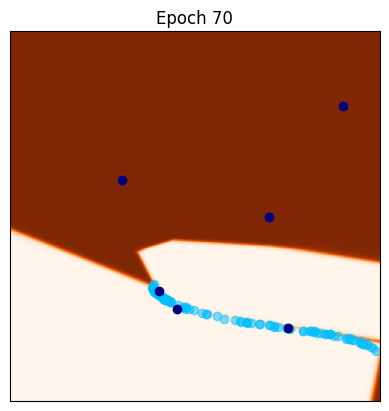

[71/100] 	Loss_D: 0.5341	Loss_G: 1.9751
[72/100] 	Loss_D: 0.6177	Loss_G: 1.7024
[73/100] 	Loss_D: 0.5972	Loss_G: 2.2627
[74/100] 	Loss_D: 0.6283	Loss_G: 1.1824
[75/100] 	Loss_D: 0.8151	Loss_G: 2.6485
[76/100] 	Loss_D: 0.6107	Loss_G: 2.0569
[77/100] 	Loss_D: 0.6373	Loss_G: 2.0891
[78/100] 	Loss_D: 0.6305	Loss_G: 2.0668
[79/100] 	Loss_D: 0.6073	Loss_G: 2.1102
[80/100] 	Loss_D: 0.6381	Loss_G: 2.1537


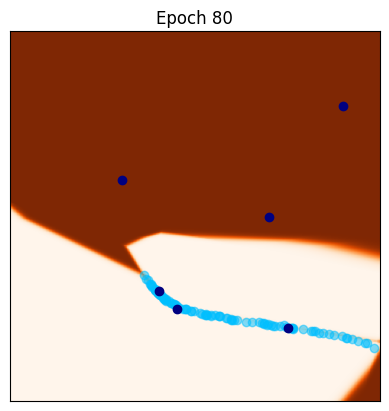

[81/100] 	Loss_D: 0.6531	Loss_G: 1.7798
[82/100] 	Loss_D: 0.7508	Loss_G: 1.7811
[83/100] 	Loss_D: 0.6785	Loss_G: 1.2646
[84/100] 	Loss_D: 0.6781	Loss_G: 1.3256
[85/100] 	Loss_D: 0.6285	Loss_G: 1.6270
[86/100] 	Loss_D: 0.7110	Loss_G: 1.5083
[87/100] 	Loss_D: 0.7331	Loss_G: 1.2658
[88/100] 	Loss_D: 0.6414	Loss_G: 1.9012
[89/100] 	Loss_D: 0.6556	Loss_G: 1.7572
[90/100] 	Loss_D: 0.6060	Loss_G: 1.6823


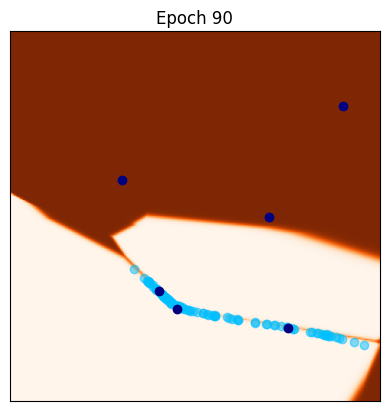

[91/100] 	Loss_D: 0.6054	Loss_G: 1.2323
[92/100] 	Loss_D: 0.6510	Loss_G: 0.8182
[93/100] 	Loss_D: 0.7886	Loss_G: 2.6410
[94/100] 	Loss_D: 0.6471	Loss_G: 1.3093
[95/100] 	Loss_D: 0.6736	Loss_G: 1.6674
[96/100] 	Loss_D: 0.5701	Loss_G: 0.9730
[97/100] 	Loss_D: 0.5608	Loss_G: 0.9141
[98/100] 	Loss_D: 0.6158	Loss_G: 1.3047
[99/100] 	Loss_D: 0.5946	Loss_G: 0.8396


<All keys matched successfully>

In [11]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
D = DGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))
G = Generator(n_in = n_in, n_out = d, n_hid = 10, nlayers = 3, device = device)
optimG = optim.Adam(G.parameters(), lr = lr)
Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        optimD.zero_grad()
        ### ... ###
        z = torch.randn(b, n_in, device = device)
        g_z = G(z).detach()
        Dloss = -torch.mean(torch.log(D(y))) - torch.mean(torch.log(1 - D(g_z)))
        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()
        z = torch.randn(b, n_in, device = device)
        g_z = G(z)
        Gloss = -torch.mean(torch.log(D(g_z)))
        Gloss.backward()
        optimG.step()
    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

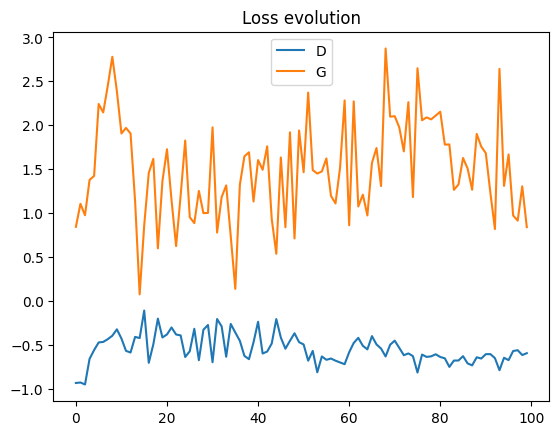

In [12]:
### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

[0/100] 	Loss_D: 0.5946	Loss_G: -0.0000


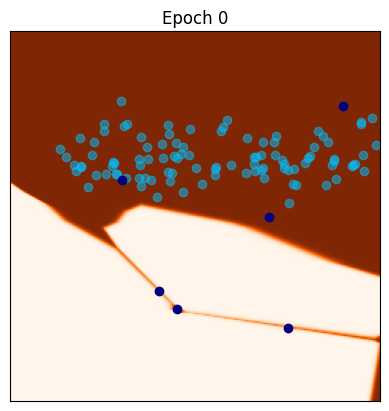

[1/100] 	Loss_D: 0.5946	Loss_G: -0.0000
[2/100] 	Loss_D: 0.5946	Loss_G: -0.0000
[3/100] 	Loss_D: 0.5946	Loss_G: -0.0000
[4/100] 	Loss_D: 0.5946	Loss_G: -0.0000
[5/100] 	Loss_D: 0.5946	Loss_G: 0.0000
[6/100] 	Loss_D: 0.5946	Loss_G: -0.0000


KeyboardInterrupt: 

In [15]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=1000

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators

G = Generator(n_in = n_in, n_out = d, n_hid = 10, nlayers = 3, device = device)
optimG = optim.Adam(G.parameters(), lr = lr)
Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):


    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()
        z = torch.randn(b, n_in, device = device)
        g_z = G(z)
        Gloss = -torch.mean(torch.log(D(g_z)))
        Gloss.backward()
        optimG.step()
    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

The generator doesn't learn anything, it is normal since the discriminator is know, and gives a probability of 1 to the whole upper region. So the generator just have to keep points in this region, and from ther it stop learning. 

It just shows that the discriminator is not optimal.